In [3]:
import numpy as np
from datetime import datetime as dt
from matplotlib import pyplot as plt
%matplotlib inline
# Предварительно данные разбиты на 2 .csv файла
# test_SPSS_3.csv - истинные значения до марта 2015, далее пропуски
# test_SPSS_3_pred.csv - истинные значения до сентября 2014, начиная с октября - предсказания Мегафона
# Читаем файл с истинными значениями
data = np.genfromtxt('C:/Megafon/test_SPSS_3.csv',dtype = [('date','S10'), ('KPI1','float64'), ('KPI2','float64'), 
                                                                ('KPI3','float64'), ('KPI4','float64'), ('KPI5', 'float64')],
                     delimiter = ',', skip_header = 1)
# Читаем файл, содержащий предсказания Мегафона
megafon = np.genfromtxt('C:/Megafon/test_SPSS_pred.csv',dtype = [('date','S10'), ('KPI1','float64'), ('KPI2','float64'), 
                                                                      ('KPI3','float64'), ('KPI4','float64'), ('KPI5', 'float64')],
                        delimiter = ',', skip_header = 1)
# Задаем конец обучения и теста (значения заданы так, что если x - весь ряд, то x[:train_end] - значения обучающего периода
# x[train_end:test_end] = мзвестные значения тестового
full_len = len(data)
train_end = 84 
test_end = 90

# Извлекаем номера месяцев. Для реализованной здесь модели они не нужны (использовались в первых моделях регрессии)
months = np.array([dt.strptime(data[i][0].decode('utf-8'), '%d.%m.%Y').month for i in range(full_len)])
# Извлекаем значения KPI
KPI = {}
KPI[1] = np.array([data[i][1]/(10**6) for i in range(full_len)]) # KPI1 values
KPI[2] = np.array([data[i][2]/(10**6) for i in range(full_len)]) # KPI2 values
KPI[3] = np.array([data[i][3]/(10**6) for i in range(full_len)]) # KPI3 values
KPI[4] = np.array([data[i][4]/(10**6) for i in range(full_len)]) # KPI4 values
KPI[5] = np.array([data[i][5]/(10**6) for i in range(full_len)]) # KPI5 values
# Извлекаем значения предсказаний Мегафона
M_KPI = {}
M_KPI[1] = np.array([megafon[i][1]/(10**6) for i in range(train_end, full_len)]) # megafon predictions
M_KPI[2] = np.array([megafon[i][2]/(10**6) for i in range(train_end, full_len)])
M_KPI[3] = np.array([megafon[i][3]/(10**6) for i in range(train_end, full_len)])
M_KPI[4] = np.array([megafon[i][4]/(10**6) for i in range(train_end, full_len)])
M_KPI[5] = np.array([megafon[i][5]/(10**6) for i in range(train_end, full_len)])


In [9]:
# Функция, формирующая матрицу по временному ряду S, M - длина гусеницы
def make_matrix(S, M):
    X = []
    i = 0
    K = len(S)-M+1
    while i < K:
        X.append(S[i:i+M])
        i += 1
    X = np.matrix(X).transpose()
    return X

# Функция svd для временного ряда S. M - длина гусеницы
def SVD(S, M):
    N = len(S)
    K = N-M+1
    X = make_matrix(S, M)
    V = 1./K*np.dot(np.transpose(X),X)
    P,L,Pt = np.linalg.svd(V)
    return X,P,L 

# Преобразование матрицы ряда в значения ряда
def get_ts(X):
    ts = np.array([])
    X_flip = np.fliplr(X)
    for i in np.arange(X.shape[1]-1,-1*X.shape[0], -1):
        ts = np.append(ts,np.mean(np.diagonal(X_flip,i)))
    return ts

# Функция конструирования прогноза
# P - матрица векторов разложения SVD
# r_list - номера векторов, которые используются для формирования предсказания
# X - матрица, по которой строится разложение
# t - число шагов, для которых нужно сделать предсказание
#  y - истинные значения известного куска периода предсказания (конец обучающей выборки)
# ulv - может принимать значения: False - известные значения в периоде предсказания
# не используются для дальнейших предсказаний, True - --- используются
def predict(P, r_list, X, t,y, ulv):
    M = X.shape[1]
    N = len(KPI)
    KPI_p = np.array([])
    Q = X[-1,1:].transpose()
    for j in range(t):
        v = P[M-1,r_list]
        Vr = P[:M-1,r_list]
        z = np.linalg.inv(np.dot(np.transpose(Vr),Vr))
        z = z.dot(Vr.transpose())
        z = v.dot(z)
        z = z.dot(Q)
        KPI_p = np.append(KPI_p,z)
        # Cдвиг окна для слудющего предсказания
        if ulv: # Если True
            if j in range(len(y)): # При наличии добавляем известные значения
                Q = np.vstack([Q[1:], np.matrix(y[j])])
            else: # Иначе добавлем предыдущее предсказание
                Q = np.vstack([Q[1:], np.matrix(z)])
        else:
            Q = np.vstack([Q[1:], np.matrix(z)])
    return KPI_p

# Расчет ошибки на тестовом периоде
# a - вектор предсказаний
# y - вектор истинных значений
def quality(a, y):
    return np.mean(100*np.abs(a - y)/y)

# Функця рассчета качества предсказания для подмножеств собственных векторов SVD следующего вида:
# [0], [0,1], [0,1,2], и т.д.
def set_list_r(X, P, y, t, ulv):
    Y = np.dot(X, P)
    r_n = P.shape[0]
    Y_c = np.matrix(np.zeros(Y.shape, dtype=np.float))
    list_r = []
    Pt = P.transpose()
    list_X = []
    list_a = []
    list_q = []
    for r in range(r_n):
        list_r.append(r)
        Y_c[:,r] = Y[:,r]
        X_r = np.dot(Y_c, Pt)
        list_X.append(X_r)
        list_a.append(predict(P, list_r,X,t,y, ulv))
        list_q.append(quality(list_a[-1][:len(y)],y))
    return list_q, list_a, list_X # Возвращает список значений ошибки, набор предсказаний и набор восстановденных матриц

# Фунция, которая выявляет оптимальную длину окна и возвращает предсказания
# TS_train - весь обучающий ряд
# len_to_test - какое количество наблюдений с конца от обучающего ряда, будет использоваться для тестирования
# max_delim - макисмальный делитель (Длина окна = (длина(TS_train)-len_to_test)/d, max_delim = max(d)
# len_pred - длина тестового периода
# use_last_vals - булева переменная: использовать или нет последние значения обучающей выборки
# для предсказаний в тестовом периоде, по умолчанию - не использовать (False)
# lim - лимит разницы ошибки для выбора оптимального параметра, по умолчанию 1
def make_prediction_SSA(TS_train, len_to_test, max_delim, len_pred, use_last_vals = None, lim = None):
    if lim is None:
        lim = 1
    if use_last_vals is None:
        use_last_vals = False
    opt_q = []
    opt_a = []
    opt_r = []
    opt_X = []
    # для набора делителей длины обучающей выборки
    k_range = range(2,max_delim+1)
    for k in k_range:
        # применяем SSA
        X,P,L = SVD(TS_train[:-len_to_test],(len(TS_train)-len_to_test)/k)
        # оцениваем качество по подвыборкам собственный векторов
        list_q, list_a, list_X = set_list_r(X, P, TS_train[-len_to_test:], len_to_test+len_pred, use_last_vals)
        # выбираем наилучшее подмножество собственных векторов по максимальной разнице логарифмов собственных чисел
        log_L = np.log(L)
        id_max_diff_L = np.argmax(log_L[:-1]-log_L[1:])
        opt_q.append(list_q[id_max_diff_L])
        opt_a.append(list_a[id_max_diff_L])
        opt_X.append(list_X[id_max_diff_L])
    opt_q = np.array(opt_q)
    print(opt_q)
    diff_q = opt_q[:-1]-opt_q[1:]
    idx = 0
    i = 0
    # выбор оптимального делителя длины обучающей выборки
    flag1 = diff_q[i]>lim
    flag2 = abs(opt_q[i+1]-opt_q[idx])<lim
    while flag1 or flag2:
        if flag1:
            idx = i+1
        i += 1
        flag1 = diff_q[i]>lim
        flag2 = abs(opt_q[i+1]-opt_q[idx])<lim
    print(idx)
    pred = opt_a[idx]
    q = opt_q[idx]
    X_r = opt_X[idx]
    return pred[len_to_test:], pred[:len_to_test], q, X_r # возращает предсказания на тестовом периоде, на конце обучающего,
    # ошибку на конце обучающего, восстановленную по соответствующим параметрам матрицу X

[ 20.97323487   2.23687683   5.37227495   6.30422614   5.99682582
   4.84468509   4.13222426]
1


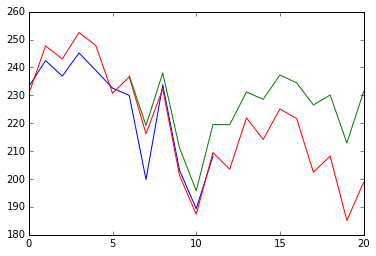

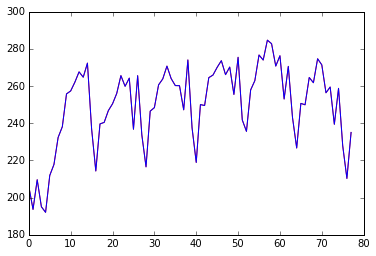

Train quality: 2.23687682849
Test quality: 2.37821352859
Megafon quality: 4.5626906115


In [51]:
# применяем к первому KPI, последние значения обучающей выборки НЕ используются для предсказаний на тестовом периоде
n1 = 6
max_delim1 = 8
pred1,pred_train1, q1, X1 = make_prediction_SSA(KPI[1][:train_end],n1,max_delim1,full_len-train_end)
plt.figure
plt.plot(KPI[1][train_end-n1:],'b-')
plt.plot(np.hstack([pred_train1, pred1]), 'r-')
plt.plot(range(n1,len(KPI[1][train_end-n1:])),M_KPI[1], 'g-')
plt.show()
plt.figure
plt.plot(get_ts(X1),'r-')
plt.plot(KPI[1][:train_end-n1],'b-')
plt.show()
print("Train quality: "+str(q1))
print("Test quality: "+str(quality(pred1[:(test_end-train_end)],KPI[1][train_end:test_end])))
print("Megafon quality: "+str(quality(M_KPI[1][:test_end-train_end],KPI[1][train_end:test_end])))

[ 4.76056602  2.24015258  4.64319656  5.68489977  5.64896084  4.67147304
  4.04428753]
1


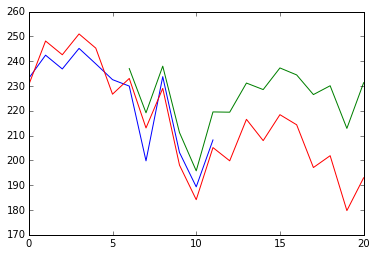

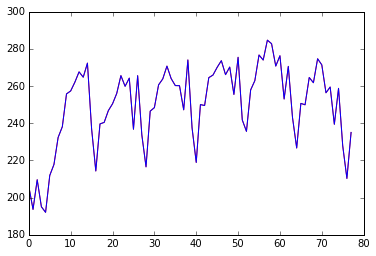

Train quality: 2.24015258178
Test quality: 2.78334561958
Megafon quality: 4.5626906115


In [52]:
# применяем к первому KPI, последние значения обучающей выборки используются для предсказаний на тестовом периоде
n1 = 6
max_delim1 = 8
pred1,pred_train1, q1, X1 = make_prediction_SSA(KPI[1][:train_end],n1,max_delim1,full_len-train_end, True)
plt.figure
plt.plot(KPI[1][train_end-n1:],'b-')
plt.plot(np.hstack([pred_train1, pred1]), 'r-')
plt.plot(range(n1,len(KPI[1][train_end-n1:])),M_KPI[1], 'g-')
plt.show()
plt.figure
plt.plot(get_ts(X1),'r-')
plt.plot(KPI[1][:train_end-n1],'b-')
plt.show()
print("Train quality: "+str(q1))
print("Test quality: "+str(quality(pred1[:(test_end-train_end)],KPI[1][train_end:test_end])))
print("Megafon quality: "+str(quality(M_KPI[1][:test_end-train_end],KPI[1][train_end:test_end])))

[ 26.16010713   1.58485301   1.55613959   1.13258378   0.68363594
   1.68743173   9.1457411 ]
1


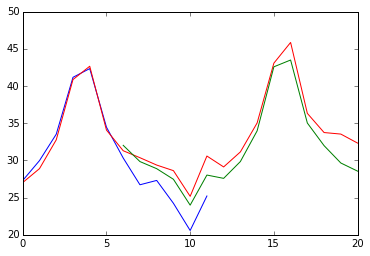

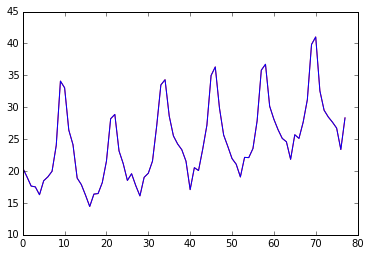

Train quality: 1.58485300785
Test quality: 14.3537074435
Megafon quality: 10.6844644609


In [10]:
# применяем ко второму KPI, последние значения обучающей выборки НЕ используются для предсказаний на тестовом периоде
n2 = 6
max_delim2 = 8
pred2,pred_train2, q2, X2 = make_prediction_SSA(KPI[2][:train_end],n2,max_delim2,full_len-train_end)
plt.figure
plt.plot(KPI[2][train_end-n2:],'b-')
plt.plot(np.hstack([pred_train2, pred2]), 'r-')
plt.plot(range(n2,len(KPI[2][train_end-n2:])),M_KPI[2], 'g-')
plt.show()
plt.figure
plt.plot(get_ts(X2),'r-')
plt.plot(KPI[2][:train_end-n2],'b-')
plt.show()
print("Train quality: "+str(q2))
print("Test quality: "+str(quality(pred2[:(test_end-train_end)],KPI[2][train_end:test_end])))
print("Megafon quality: "+str(quality(M_KPI[2][:test_end-train_end],KPI[2][train_end:test_end])))

[ 17.75338521   1.61196204   1.57006918   1.14591643   0.68226163
   1.63874165   8.86222615]
1


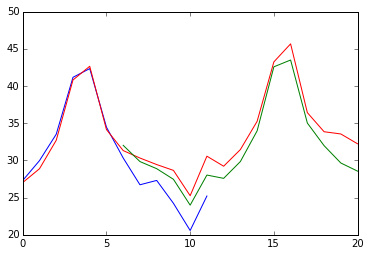

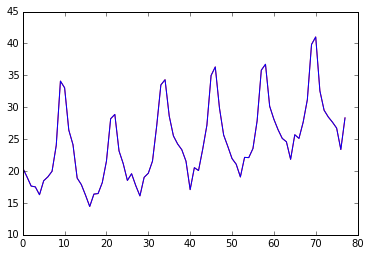

Train quality: 1.6119620397
Test quality: 14.4602557573
Megafon quality: 10.6844644609


In [54]:
# применяем ко второму KPI, последние значения обучающей выборки используются для предсказаний на тестовом периоде
n2 = 6
max_delim2 = 8
pred2,pred_train2, q2, X2 = make_prediction_SSA(KPI[2][:train_end],n2,max_delim2,full_len-train_end,True)
plt.figure
plt.plot(KPI[2][train_end-n2:],'b-')
plt.plot(np.hstack([pred_train2, pred2]), 'r-')
plt.plot(range(n2,len(KPI[2][train_end-n2:])),M_KPI[2], 'g-')
plt.show()
plt.figure
plt.plot(get_ts(X2),'r-')
plt.plot(KPI[2][:train_end-n2],'b-')
plt.show()
print("Train quality: "+str(q2))
print("Test quality: "+str(quality(pred2[:(test_end-train_end)],KPI[2][train_end:test_end])))
print("Megafon quality: "+str(quality(M_KPI[2][:test_end-train_end],KPI[2][train_end:test_end])))

[ 33.01551725   8.92466768   3.61932682   3.75701612   2.27976251
   3.56800031   4.78641341]
4


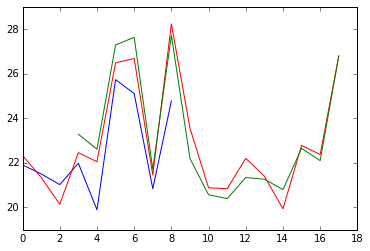

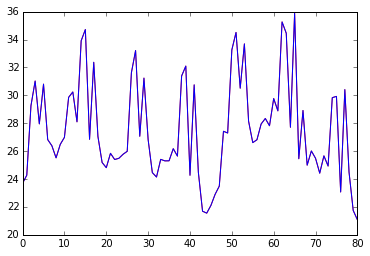

Train quality: 2.27976251265
Test quality: 6.50871012867
Megafon quality: 8.61923574358


In [55]:
# применяем к nhtnmtve KPI, последние значения обучающей выборки НЕ используются для предсказаний на тестовом периоде
n3 = 3
max_delim3 = 8
pred3,pred_train3, q3, X3 = make_prediction_SSA(KPI[3][:train_end],n3,max_delim3,full_len-train_end)
plt.figure
plt.plot(KPI[3][train_end-n3:],'b-')
plt.plot(np.hstack([pred_train3, pred3]), 'r-')
plt.plot(range(n3,len(KPI[3][train_end-n3:])),M_KPI[3], 'g-')
plt.show()
plt.figure
plt.plot(get_ts(X3),'r-')
plt.plot(KPI[3][:train_end-n3],'b-')
plt.show()
print("Train quality: "+str(q3))
print("Test quality: "+str(quality(pred3[:(test_end-train_end)],KPI[3][train_end:test_end])))
print("Megafon quality: "+str(quality(M_KPI[3][:test_end-train_end],KPI[3][train_end:test_end])))

[ 28.52383799   7.57286477   3.77502632   3.97359017   2.29031168
   3.63131968   4.78857585]
4


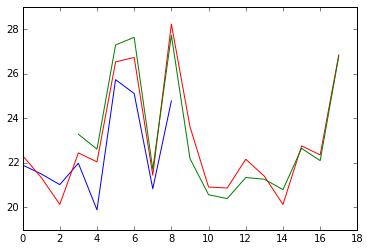

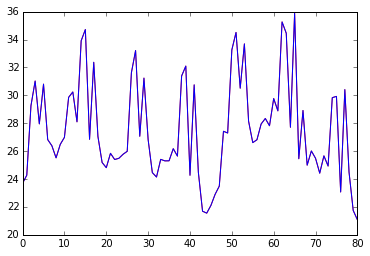

Train quality: 2.29031167557
Test quality: 6.5417983661
Megafon quality: 8.61923574358


In [56]:
# применяем к третьему KPI, последние значения обучающей выборки используются для предсказаний на тестовом периоде
n3 = 3
max_delim3 = 8
pred3,pred_train3, q3, X3 = make_prediction_SSA(KPI[3][:train_end],n3,max_delim3,full_len-train_end,True)
plt.figure
plt.plot(KPI[3][train_end-n3:],'b-')
plt.plot(np.hstack([pred_train3, pred3]), 'r-')
plt.plot(range(n3,len(KPI[3][train_end-n3:])),M_KPI[3], 'g-')
plt.show()
plt.figure
plt.plot(get_ts(X3),'r-')
plt.plot(KPI[3][:train_end-n3],'b-')
plt.show()
print("Train quality: "+str(q3))
print("Test quality: "+str(quality(pred3[:(test_end-train_end)],KPI[3][train_end:test_end])))
print("Megafon quality: "+str(quality(M_KPI[3][:test_end-train_end],KPI[3][train_end:test_end])))

[ 4244.08401306   140.37259463     6.3285477     13.95942049    13.59382479
    13.01111589    12.44867012]
2


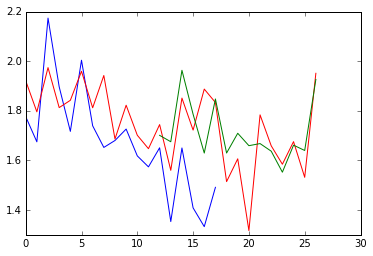

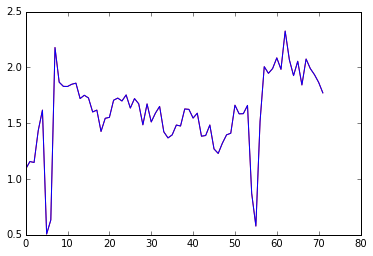

Train quality: 6.32854770326
Test quality: 19.9892890472
Megafon quality: 19.7918718721


In [57]:
# применяем к четвертому KPI, последние значения обучающей выборки НЕ используются для предсказаний на тестовом периоде
n4 = 12
max_delim4 = 8
pred4,pred_train4, q4, X4 = make_prediction_SSA(KPI[4][:train_end],n4,max_delim4,full_len-train_end)
plt.figure
plt.plot(KPI[4][train_end-n4:],'b-')
plt.plot(np.hstack([pred_train4, pred4]), 'r-')
plt.plot(range(n4,len(KPI[4][train_end-n4:])),M_KPI[4], 'g-')
plt.show()
plt.figure
plt.plot(get_ts(X4),'r-')
plt.plot(KPI[4][:train_end-n4],'b-')
plt.show()
print("Train quality: "+str(q4))
print("Test quality: "+str(quality(pred4[:(test_end-train_end)],KPI[4][train_end:test_end])))
print("Megafon quality: "+str(quality(M_KPI[4][:test_end-train_end],KPI[4][train_end:test_end])))

[ 215.81050824   58.82755486    6.65189193   13.9075328    13.19292765
   12.40755992   11.81493004]
2


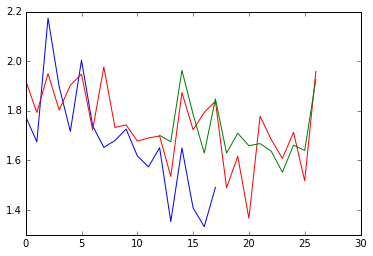

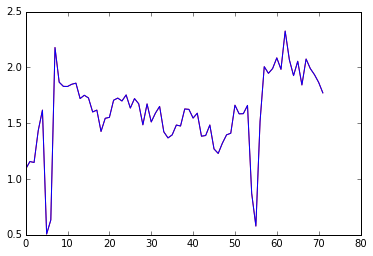

Train quality: 6.65189192617
Test quality: 18.3454392013
Megafon quality: 19.7918718721


In [58]:
# применяем к четвертому KPI, последние значения обучающей выборки используются для предсказаний на тестовом периоде
n4 = 12
max_delim4 = 8
pred4,pred_train4, q4, X4 = make_prediction_SSA(KPI[4][:train_end],n4,max_delim4,full_len-train_end,True)
plt.figure
plt.plot(KPI[4][train_end-n4:],'b-')
plt.plot(np.hstack([pred_train4, pred4]), 'r-')
plt.plot(range(n4,len(KPI[4][train_end-n4:])),M_KPI[4], 'g-')
plt.show()
plt.figure
plt.plot(get_ts(X4),'r-')
plt.plot(KPI[4][:train_end-n4],'b-')
plt.show()
print("Train quality: "+str(q4))
print("Test quality: "+str(quality(pred4[:(test_end-train_end)],KPI[4][train_end:test_end])))
print("Megafon quality: "+str(quality(M_KPI[4][:test_end-train_end],KPI[4][train_end:test_end])))

[ 14.75746317   2.98326062   2.13774031   2.32313183   1.76349079
   2.84087339   6.90317135]
1


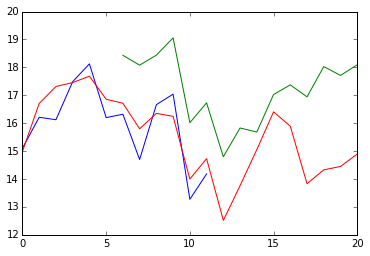

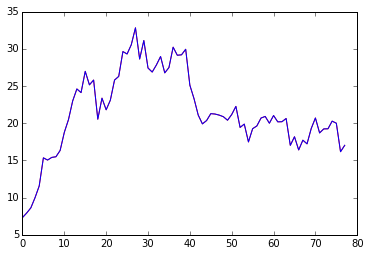

Train quality: 2.98326062402
Test quality: 4.2966216254
Megafon quality: 16.1837548138


In [60]:
# применяем к пятому KPI, последние значения обучающей выборки НЕ используются для предсказаний на тестовом периоде
n5 = 6
max_delim5 = 8
pred5,pred_train5, q5, X5 = make_prediction_SSA(KPI[5][:train_end],n5,max_delim5,full_len-train_end)
plt.figure
plt.plot(KPI[5][train_end-n5:],'b-')
plt.plot(np.hstack([pred_train5, pred5]), 'r-')
plt.plot(range(n5,len(KPI[5][train_end-n5:])),M_KPI[5], 'g-')
plt.show()
plt.figure
plt.plot(get_ts(X5),'r-')
plt.plot(KPI[5][:train_end-n5],'b-')
plt.show()
print("Train quality: "+str(q5))
print("Test quality: "+str(quality(pred5[:(test_end-train_end)],KPI[5][train_end:test_end])))
print("Megafon quality: "+str(quality(M_KPI[5][:test_end-train_end],KPI[5][train_end:test_end])))

[ 9.6448135   2.82926953  2.05468119  2.27707059  1.74763985  2.87162558
  6.9714814 ]
1


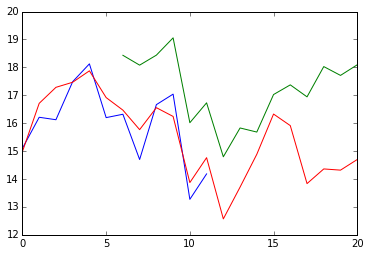

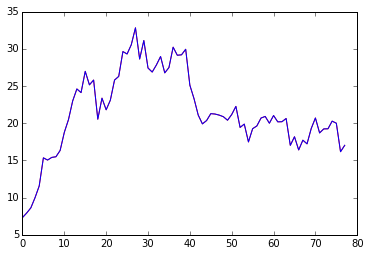

Train quality: 2.82926953113
Test quality: 3.69442512775
Megafon quality: 16.1837548138


In [61]:
# применяем к пятому KPI, последние значения обучающей выборки используются для предсказаний на тестовом периоде
n5 = 6
max_delim5 = 8
pred5,pred_train5, q5, X5 = make_prediction(KPI[5][:train_end],n5,max_delim5,full_len-train_end, True)
plt.figure
plt.plot(KPI[5][train_end-n5:],'b-')
plt.plot(np.hstack([pred_train5, pred5]), 'r-')
plt.plot(range(n5,len(KPI[5][train_end-n5:])),M_KPI[5], 'g-')
plt.show()
plt.figure
plt.plot(get_ts(X5),'r-')
plt.plot(KPI[5][:train_end-n5],'b-')
plt.show()
print("Train quality: "+str(q5))
print("Test quality: "+str(quality(pred5[:(test_end-train_end)],KPI[5][train_end:test_end])))
print("Megafon quality: "+str(quality(M_KPI[5][:test_end-train_end],KPI[5][train_end:test_end])))